In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")
clip = 10.

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    actor = Model(inputs=action_input, outputs=x)
    # actor.summary()
    # actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [6]:
#safe learning
l = 50. # cost dependency for tau
step = 200000  # num of interval
episode_step = step
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.actor.load_weights('./saved_agent/self_trigger.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 200000 steps ...
Interval 1 (0 steps performed)
 1943/10000 [====>.........................] - ETA: 40s - reward: -29.0572done, took 9.855 seconds


In [65]:
states = []
taus = []
high = np.array([np.pi, 8])
a.actor.load_weights('./saved_agent/self_trigger_05_1.h5')
for _ in range(500):
    x = np.random.uniform(low=-high, high=high)
    states.append(x)
    action = a.forward(x)
    taus.append(action[1])
states = np.array(states)

<IPython.core.display.Javascript object>


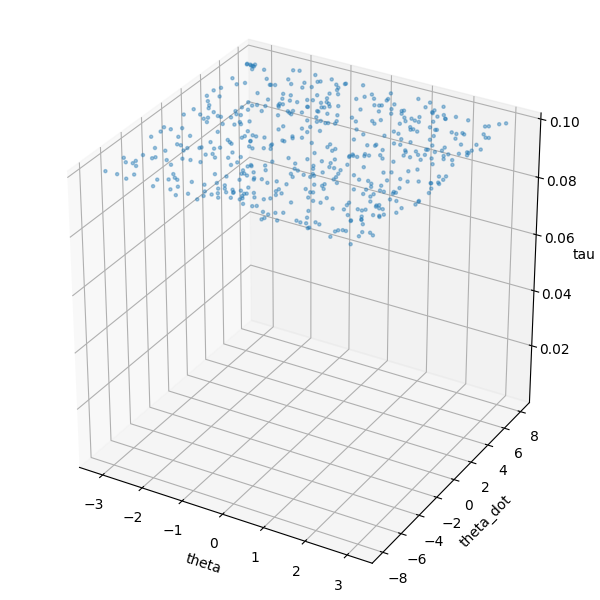

In [37]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

ax.scatter3D(states[:,0], states[:,1], taus, marker='.', alpha=0.4)

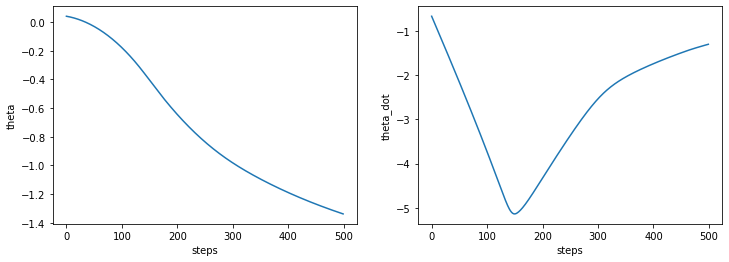

In [5]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
reward = 0
for i in range(500):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward += - 0.01 * a_agent**2 + l * tau
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.show()

In [7]:
n_states = 500
n_agents = 10
states = []
high = np.array([np.pi, 8])
for _ in range(n_states):
    x = np.random.uniform(low=-high, high=high)
    states.append(x)
states = np.array(states)

In [8]:
all_agents_taus = np.zeros((n_agents, n_states))
ag = agent((2,),(2,))
for i, age in enumerate(a.agents_log):
    if i % 10 != 0:
        continue
    ag.agent_copy_from_layers(age)
    taus = []
    for x in states:
        action = ag.forward(x)
        taus.append(action[1])
    all_agents_taus[int(i/10.)] = taus

<IPython.core.display.Javascript object>


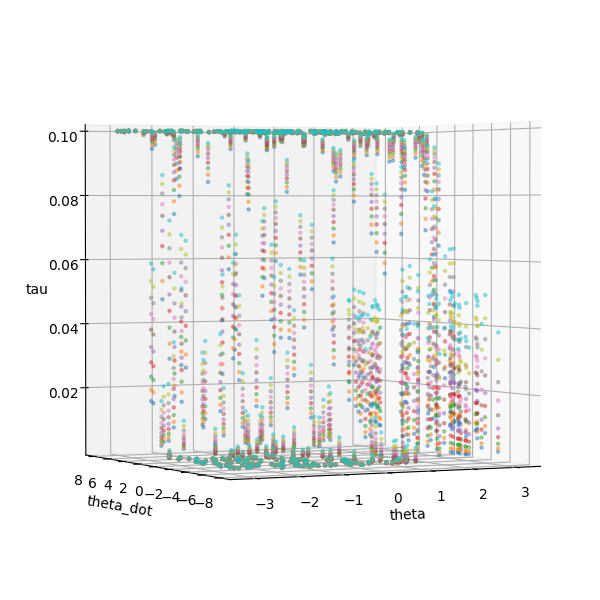

In [9]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

for tauss in all_agents_taus:
    ax.scatter3D(states[:,0], states[:,1], tauss, marker='.', alpha=0.4)

In [10]:
watched_states = np.copy(a.watched_states)

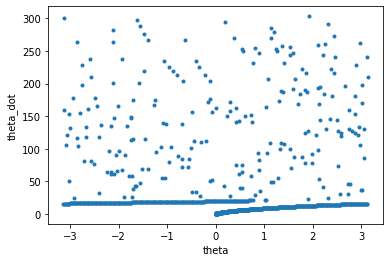

In [11]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

thetas = []
for theta in watched_states[:,0]:
    thetas.append(rad_clip(theta))
plt.xlabel('theta')
plt.ylabel('theta_dot')
plt.scatter(thetas, watched_states[:,1], marker='.')
plt.show()

In [14]:
states = []
taus = []
high = np.array([np.pi, 50])
for _ in range(5000):
    x = np.random.uniform(low=-high, high=np.array([np.pi, 350]))
    states.append(x)
    action = ag.forward(x)
    taus.append(action[1])
states = np.array(states)

<IPython.core.display.Javascript object>


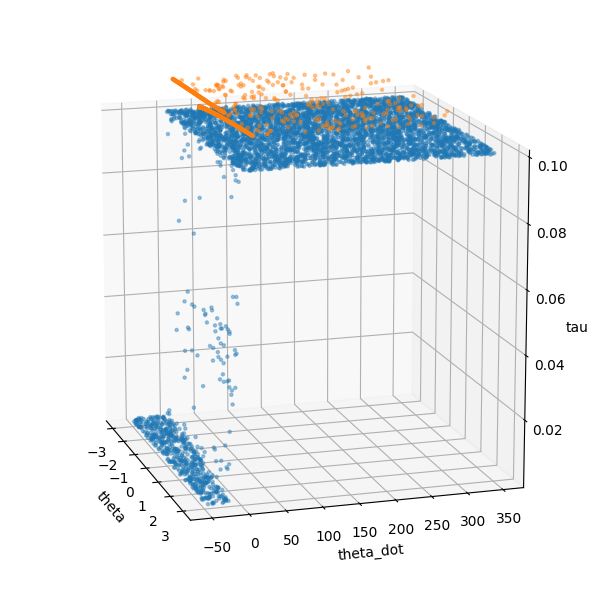

In [15]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

ax.scatter3D(states[:,0], states[:,1], taus, marker='.', alpha=0.4)
ax.scatter3D(thetas, watched_states[:,1], 0.11 * np.ones((len(thetas),)), marker='.', alpha=0.4)

In [24]:
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 200000 steps ...
Interval 1 (0 steps performed)
 2093/10000 [=====>........................] - ETA: 42s - reward: 0.9293done, took 11.298 seconds


In [25]:
all_agents_taus = np.zeros((n_agents, n_states))
ag = agent((2,),(2,))
for i, age in enumerate(a.agents_log):
    if i % 10 != 0:
        continue
    ag.agent_copy_from_layers(age)
    taus = []
    for x in states:
        action = ag.forward(x)
        taus.append(action[1])
    all_agents_taus[int(i/10.)] = taus

<IPython.core.display.Javascript object>


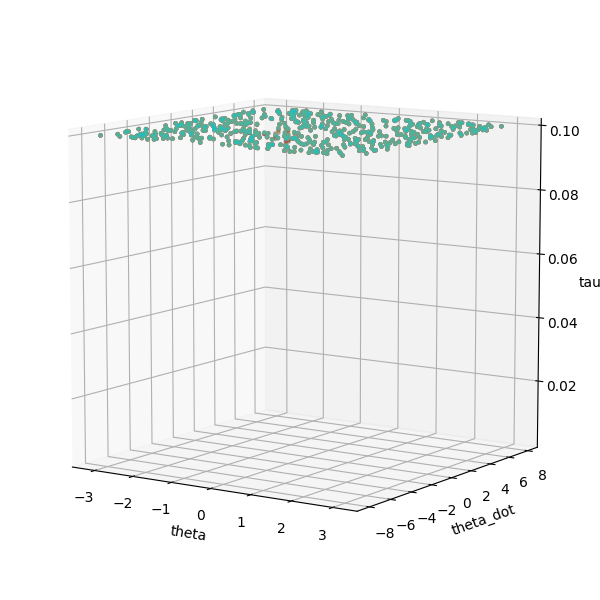

In [26]:
%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

for tauss in all_agents_taus:
    ax.scatter3D(states[:,0], states[:,1], tauss, marker='.', alpha=0.4)